# Scan aerosols and look at color dependence
=========================================================================


The purpose is to start to use PySynPhot software to calculate things on
SED, filter transmission,... For Calibration

- Sylvie Dagoret-Campagne
- Affiliation LAL-IN2P3-CNRS
- Work : LSST & StarDice
- date November 22 2017




- Read filters for LSST provided by KG May 30th 2017
- Generate LibRadTran atmosphere for any airmass - H2O - O3 combinations
- Generate the observed spectrum

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd
import os
import re 

In [4]:
import pysynphot as S

In [5]:
import astropy
import astropy.units as u
from astropy.io import fits

In [6]:
from scipy.interpolate import interp1d

In [7]:
top_pysynphot_data_dir=os.environ['PYSYN_CDBS']

In [8]:
import sys
sys.path.append('../libradtransim')
sys.path.append('../LSSTFiltersKG')
sys.path.append('../lsstphotometry')

In [9]:
import libsimulateTranspLSSTScattAbsAer as atm
import libLSSTFiltersKG as lsst
import libLSSTPhotometry as photo

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 1, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/0ac1951am_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/0bf2050hm_tmg.fits
      area: 350000.0


In [10]:
#help(atm)

# Defining LSST telescope

In [11]:
LSST_COLL_SURF=35*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [12]:
NBINS=100000
BinWidth=(WLMAX-WLMIN)/float(NBINS)
WL=np.linspace(WLMIN,WLMAX,NBINS)

In [13]:
LSST_COLL_SURF.decompose()

<Quantity 350000.0>

In [14]:
S.refs.setref(area=LSST_COLL_SURF.decompose(), waveset=None)

In [15]:
S.refs.set_default_waveset(minwave=3000, maxwave=11000, num=8000, delta=1, log=False)

In [16]:
S.refs.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 1, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/0ac1951am_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/0bf2050hm_tmg.fits
      area: 350000.0


## LSST effective filter


### Get the bands à la pysynphot

In [17]:
bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4=lsst.GetAllLSSTBands('..')

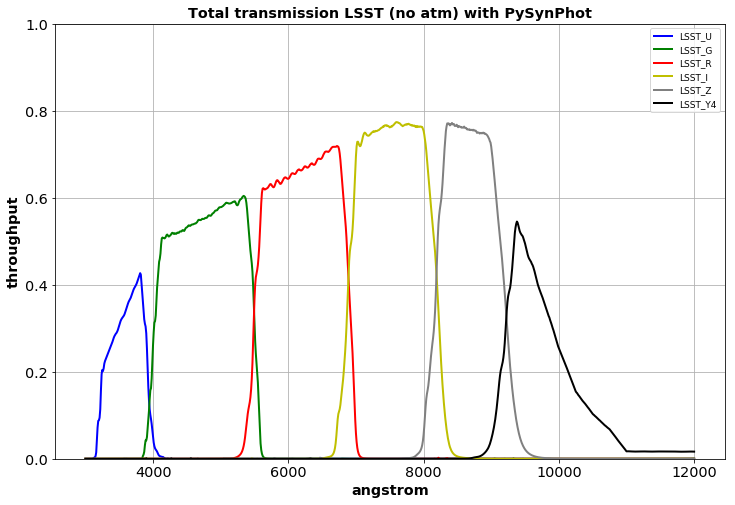

In [18]:
lsst.PlotAllLSSTBands(bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4)

## Fills all bands of LSST

### Create a LSSTTransmission object

#### One detector per airmass

In [19]:
lsstdetector=photo.LSSTTransmission('lssttel-z=1')
lsstdetector2=photo.LSSTTransmission('lssttel-z=2')

### Initialize the LSST transmission object with the bands read above

- same detector effective filter

In [20]:
lsstdetector.fill_det_allbands([bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4])
lsstdetector2.fill_det_allbands([bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4])

## Read atmosphere

- One atmosphere per airmass

### First airmass z=1

In [21]:
tau_aerosol=np.linspace(0.,0.1,10)
lambda0_aerosol=500. # nm
airmass=1.
pwv=4.0     # mm
ozone=300. # DU

In [22]:
photo_atm=photo.Atmosphere('libradtran-z=1')

In [23]:
index=0

for tau in tau_aerosol:
    path,thefile=atm.ProcessSimulationaer(airmass,pwv,ozone,lambda0_aerosol,tau) 
    fullfilename=os.path.join(path,thefile)
    atm_data=np.loadtxt(fullfilename)
    wl_atm=atm_data[:,0]
    tr_atm=atm_data[:,1]  
    if index==0:
        photo_atm.fill_array(wl_atm)        
    photo_atm.fill_array(tr_atm)        
    index+=1

--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.OUT')
('uvspec cmd: ', '/Users/dagoret//MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.OUT')
--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0.0111111111111
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer1.INP')
('Output to file        

### Second airmass z=2

In [24]:
airmass=2.

In [25]:
photo_atm2=photo.Atmosphere('libradtran-z=2')

In [26]:
index=0

for tau in tau_aerosol:
    path,thefile=atm.ProcessSimulationaer(airmass,pwv,ozone,lambda0_aerosol,tau) 
    fullfilename=os.path.join(path,thefile)
    atm_data=np.loadtxt(fullfilename)
    wl_atm=atm_data[:,0]
    tr_atm=atm_data[:,1]  
    if index==0:
        photo_atm2.fill_array(wl_atm)        
    photo_atm2.fill_array(tr_atm)        
    index+=1

--------------------------------------------
 1) airmass =  2.0
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z20_wv40_oz30_aer0.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z20_wv40_oz30_aer0.OUT')
('uvspec cmd: ', '/Users/dagoret//MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z20_wv40_oz30_aer0.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z20_wv40_oz30_aer0.OUT')
--------------------------------------------
 1) airmass =  2.0
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0.0111111111111
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z20_wv40_oz30_aer1.INP')
('Output to file        

### Check the output of simulation

#### check for airmass z=1

In [27]:
theatmosph=photo_atm.get_array()

In [28]:
pd.DataFrame(theatmosph)

,0,1,2,3,4,5,6,7,8,9,...,941,942,943,944,945,946,947,948,949,950
0,250.0,251.0,252.0,253.0,254.0,255.0,256.0,257.0,258.0,259.0,...,1191.000000,1192.000000,1193.000000,1194.000000,1195.000000,1196.000000,1197.000000,1198.000000,1199.000000,1200.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.963772,0.985182,0.985182,0.970041,0.970041,0.977899,0.977899,0.963689,0.963689,0.960683
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.960666,0.982012,0.982012,0.966929,0.966929,0.974768,0.974768,0.960614,0.960614,0.957626
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.957569,0.978851,0.978851,0.963827,0.963827,0.971647,0.971647,0.957549,0.957549,0.954578
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.954483,0.975701,0.975701,0.960735,0.960735,0.968535,0.968535,0.954494,0.954494,0.951540
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.951407,0.972561,0.972561,0.957653,0.957653,0.965434,0.965434,0.951449,0.951449,0.948511
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.948341,0.969432,0.969432,0.954581,0.954581,0.962343,0.962343,0.948413,0.948413,0.945492
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.945284,0.966312,0.966312,0.951518,0.951518,0.959262,0.959262,0.945387,0.945387,0.942483
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.942238,0.963202,0.963202,0.948466,0.948466,0.956190,0.956190,0.942370,0.942370,0.939483
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.939201,0.960102,0.960102,0.945423,0.945423,0.953129,0.953129,0.939364,0.939364,0.936493


#### check for airmass z=2

In [29]:
theatmosph2=photo_atm2.get_array()

In [30]:
pd.DataFrame(theatmosph2)

,0,1,2,3,4,5,6,7,8,9,...,941,942,943,944,945,946,947,948,949,950
0,250.0,251.0,252.0,253.0,254.0,255.0,256.0,257.0,258.0,259.0,...,1191.000000,1192.000000,1193.000000,1194.000000,1195.000000,1196.000000,1197.000000,1198.000000,1199.000000,1200.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.933192,0.970779,0.970779,0.943998,0.943998,0.956705,0.956705,0.931472,0.931472,0.927442
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.927187,0.964541,0.964541,0.937952,0.937952,0.950589,0.950589,0.925539,0.925539,0.921548
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.921221,0.958344,0.958344,0.931944,0.931944,0.944512,0.944512,0.919643,0.919643,0.915692
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.915293,0.952186,0.952186,0.925974,0.925974,0.938473,0.938473,0.913784,0.913784,0.909873
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.909404,0.946068,0.946068,0.920043,0.920043,0.932474,0.932474,0.907963,0.907963,0.904091
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.903552,0.939990,0.939990,0.914150,0.914150,0.926513,0.926513,0.902179,0.902179,0.898346
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.897738,0.933950,0.933950,0.908295,0.908295,0.920590,0.920590,0.896432,0.896432,0.892637
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.891961,0.927949,0.927949,0.902477,0.902477,0.914704,0.914704,0.890721,0.890721,0.886965
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.886221,0.921987,0.921987,0.896697,0.896697,0.908857,0.908857,0.885047,0.885047,0.881328


## Do multiplication

### Get all pysynphot passband for the atmosphere

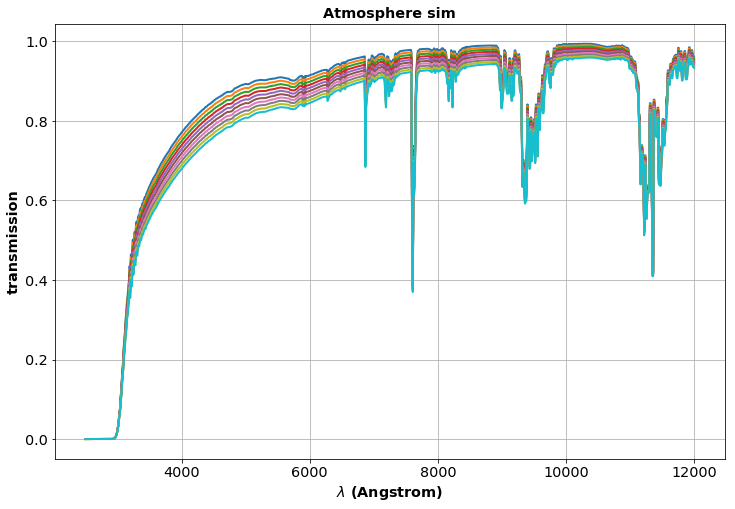

In [31]:
photo_atm.plot_pys_bp()

### Initialise the lsstdetector with the atmosphere results

#### z=1

In [32]:
all_bp_atm=photo_atm.get_pys_pb()

In [33]:
lsstdetector.fill_atm_allevents(all_bp_atm)

#### z=2

In [34]:
all_bp_atm2=photo_atm2.get_pys_pb()

In [35]:
lsstdetector2.fill_atm_allevents(all_bp_atm2)

### Multiplication of atmosphere transmission by filters transmission

In [36]:
all_transmissions=lsstdetector.make_transmissions()
all_transmissions2=lsstdetector2.make_transmissions()

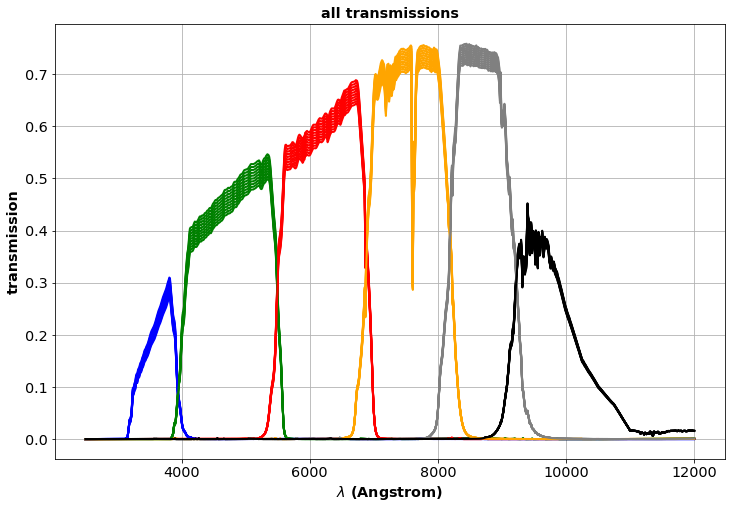

In [37]:
lsstdetector.plot_transmissions()

# Observation

## Defines the SED

In [38]:
dir_star='calspec'
dir_nostar='grid'

In [39]:
dir_submodels=['ags','bpgs','extinction','jacobi','phoenix','bc95','bz77','galactic','k93models','pickles','bkmodels','ck04models','gunnstryker','kc96']

In [40]:
SEDfile_dir=os.path.join(top_pysynphot_data_dir,dir_star)

In [41]:
filelist=os.listdir(SEDfile_dir) 

In [42]:
fits_files = [f for f in os.listdir(SEDfile_dir) if f.endswith('.fits')]

In [43]:
star_header = []
star_file_calspec = []
for filename in filelist:
    index=0
    if re.search('fits',filename) and re.search('hd',filename) and re.search('stis',filename):  #example of filename filter
        index+=1
        fullfilename = os.path.join(SEDfile_dir,filename)
        hdr = fits.getheader(fullfilename)
        star_header.append(hdr)
        star_file_calspec.append(filename)

In [44]:
star_names = []
index=0
for hdr in star_header: 
#    print index
    if index!=433:
        star_name=star_header[index]['TARGETID']
        star_names.append(star_name)
        index+=1
    else:
        print '>>>>>> skip file # ',index, 'BAD HEADER'
        print '>>>>>> filename = ', filelist[index]
        print hdr
        index+=1

In [45]:
star_names_sorted=sorted(star_names,key=star_names.count,reverse=True) 
star_names_sorted_upper = map(lambda s: s.upper(), star_names_sorted)

In [46]:
star_names_set=set(star_names_sorted_upper)

In [47]:
StarDict= {}
for star in star_names_set:
    print star,': \n'
    star_set_of_file= []
    tag_upper='^'+star.upper()+'*'
    tag_lower='^'+star.lower()+'*'
    for thefile in fits_files:
        if re.search(tag_upper,thefile) or re.search(tag_lower,thefile):         
            star_set_of_file.append(thefile)
    #StarDict[star]=sorted(star_set_of_file,key=star_names.count,reverse=True)
    StarDict[star]=sorted(star_set_of_file,key=star_names.count)
    print StarDict[star] ,'\n'

HD205905 : 

['hd205905_stis_001.fits', 'hd205905_stis_002.fits', 'hd205905_stis_003.fits'] 

HD14943 : 

['hd14943_stis_001.fits', 'hd14943_stis_002.fits', 'hd14943_stis_003.fits'] 

HD37725 : 

['hd37725_stis_001.fits', 'hd37725_stis_002.fits', 'hd37725_stis_003.fits'] 

HD160617 : 

['hd160617_stis_001.fits', 'hd160617_stis_002.fits', 'hd160617_stis_003.fits'] 

HD159222 : 

['hd159222_stis_001.fits', 'hd159222_stis_002.fits', 'hd159222_stis_003.fits'] 

HD031128 : 

['hd031128_stis_001.fits', 'hd031128_stis_002.fits', 'hd031128_stis_003.fits'] 

HD209458 : 

['hd209458_stisnic_002.fits', 'hd209458_stisnic_003.fits', 'hd209458_stisnic_004.fits', 'hd209458_stisnic_005.fits', 'hd209458_stisnic_006.fits'] 

HD111980 : 

['hd111980_stis_001.fits', 'hd111980_stis_002.fits', 'hd111980_stis_003.fits'] 

HD009051 : 

['hd009051_stis_001.fits', 'hd009051_stis_002.fits', 'hd009051_stis_003.fits'] 

HD60753 : 

['hd60753_stis_001.fits', 'hd60753_stis_002.fits', 'hd60753_stis_003.fits'] 

HD180

### Build SED list

In [48]:
all_sed=[]
for keystar in StarDict:
    the_files=StarDict[keystar]
    if(len(the_files))>0 and keystar != 'SUN_REFERENCE':
        #print sorted(the_files,reverse=True)        
        selected_file=the_files[0]
        selected_fullfile=os.path.join(SEDfile_dir,selected_file)        
        sed=S.FileSpectrum(selected_fullfile)
        all_sed.append(sed)
        

Warning, 6 of 3739 bins contained negative fluxes; they have been set to zero.
Warning, 22 of 4682 bins contained negative fluxes; they have been set to zero.
Warning, 27 of 4682 bins contained negative fluxes; they have been set to zero.
Warning, 12 of 3739 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 3739 bins contained negative fluxes; they have been set to zero.
Warning, 53 of 4684 bins contained negative fluxes; they have been set to zero.
Warning, 3 of 4683 bins contained negative fluxes; they have been set to zero.
Warning, 12 of 3738 bins contained negative fluxes; they have been set to zero.
Warning, 44 of 4685 bins contained negative fluxes; they have been set to zero.
Warning, 17 of 3740 bins contained negative fluxes; they have been set to zero.
Warning, 1 of 3740 bins contained negative fluxes; they have been set to zero.
Warning, 19 of 3740 bins contained negative fluxes; they have been set to zero.


Warning, 6 of 3739 bins contained negative fluxes; they have been set to zero.
Warning, 22 of 4682 bins contained negative fluxes; they have been set to zero.
Warning, 27 of 4682 bins contained negative fluxes; they have been set to zero.
Warning, 12 of 3739 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 3739 bins contained negative fluxes; they have been set to zero.
Warning, 53 of 4684 bins contained negative fluxes; they have been set to zero.
Warning, 3 of 4683 bins contained negative fluxes; they have been set to zero.
Warning, 12 of 3738 bins contained negative fluxes; they have been set to zero.
Warning, 44 of 4685 bins contained negative fluxes; they have been set to zero.
Warning, 17 of 3740 bins contained negative fluxes; they have been set to zero.
Warning, 1 of 3740 bins contained negative fluxes; they have been set to zero.
Warning, 19 of 3740 bins contained negative fluxes; they have been set to zero.


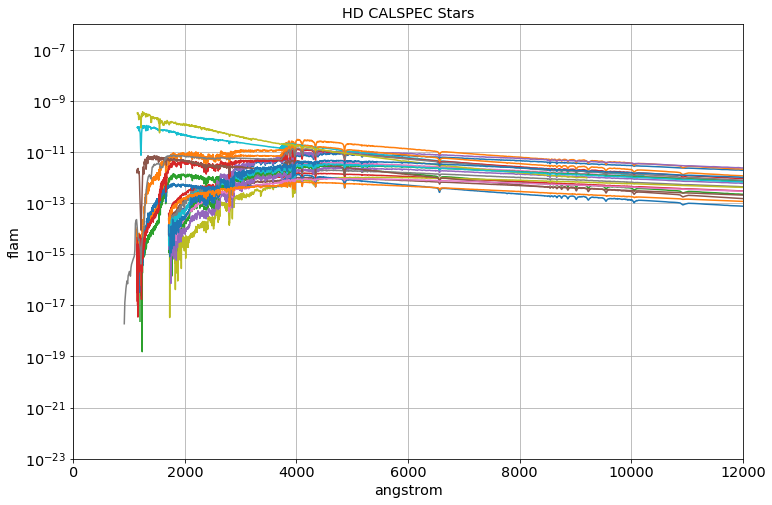

In [49]:
for keystar in StarDict:
    the_files=StarDict[keystar]
    if(len(the_files))>0 and keystar != 'SUN_REFERENCE':
        #print sorted(the_files,reverse=True)
        
        selected_file=the_files[0]
        selected_fullfile=os.path.join(SEDfile_dir,selected_file)
        
        sed=S.FileSpectrum(selected_fullfile)

        
        plt.semilogy(sed.wave,sed.flux,label=keystar)
        plt.xlim(0, 12000)
        plt.ylim(1e-23, 1e-6)
        plt.xlabel(sed.waveunits)
        plt.ylabel(sed.fluxunits)
        plt.grid(True)
 #       plt.legend(loc='best')
#    plt.title(os.path.basename(S.Vega.name))
    plt.title("HD CALSPEC Stars")
    plt.savefig("calspec_hd_log.png")

Warning, 6 of 3739 bins contained negative fluxes; they have been set to zero.
Warning, 22 of 4682 bins contained negative fluxes; they have been set to zero.
Warning, 27 of 4682 bins contained negative fluxes; they have been set to zero.
Warning, 12 of 3739 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 3739 bins contained negative fluxes; they have been set to zero.
Warning, 53 of 4684 bins contained negative fluxes; they have been set to zero.
Warning, 3 of 4683 bins contained negative fluxes; they have been set to zero.
Warning, 12 of 3738 bins contained negative fluxes; they have been set to zero.
Warning, 44 of 4685 bins contained negative fluxes; they have been set to zero.
Warning, 17 of 3740 bins contained negative fluxes; they have been set to zero.
Warning, 1 of 3740 bins contained negative fluxes; they have been set to zero.
Warning, 19 of 3740 bins contained negative fluxes; they have been set to zero.


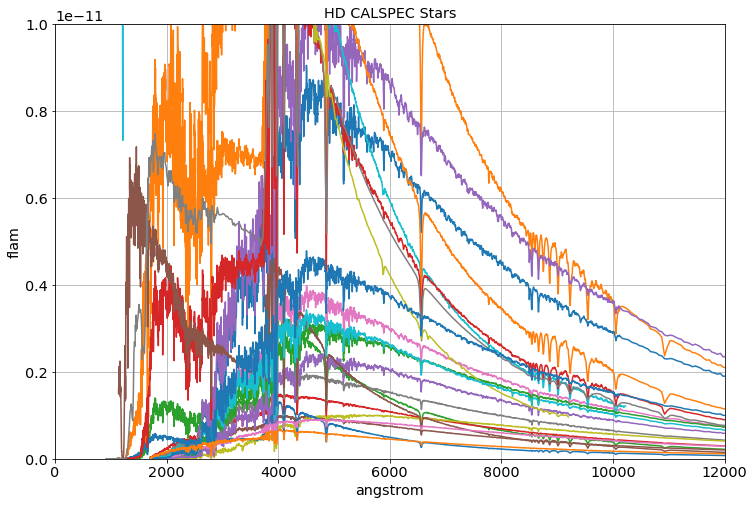

In [50]:
for keystar in StarDict:
    the_files=StarDict[keystar]
    if(len(the_files))>0 and keystar != 'SUN_REFERENCE':
        #print sorted(the_files,reverse=True)
        selected_file=the_files[0]
        selected_fullfile=os.path.join(SEDfile_dir,selected_file)
        sed=S.FileSpectrum(selected_fullfile)       
        plt.plot(sed.wave,sed.flux,label=keystar)
        plt.xlim(0, 12000)
        plt.ylim(1e-23, 1e-11)
        plt.xlabel(sed.waveunits)
        plt.ylabel(sed.fluxunits)
        plt.grid(True)
 #       plt.legend(loc='best')
#    plt.title(os.path.basename(S.Vega.name))
    plt.title("HD CALSPEC Stars")
    plt.savefig("calspec_hd_lin.png")

- flam unit is erg per sec per cm2 per angstrom

## Defines all the  observation

In [51]:
rt_observations=photo.LSSTObservation('libradtran_aerosols-z=1')
rt_observations2=photo.LSSTObservation('libradtran_aerosols-z=2')

In [52]:
rt_observations.fill_sed(all_sed)
rt_observations.fill_transmission(all_transmissions)

In [53]:
rt_observations2.fill_sed(all_sed)
rt_observations2.fill_transmission(all_transmissions2)

In [54]:
NBSED=rt_observations.get_NBSED()

In [55]:
print 'Number of SED :', NBSED

Number of SED : 22


In [56]:
all_obs=rt_observations.make_observations()

((ATM_1 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_R)) does

((ATM_5 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_G)) doe

((ATM_2 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_U)) doe

In [57]:
all_obs2=rt_observations2.make_observations()

((ATM_1 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_R)) does

((ATM_6 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_G)) doe

((ATM_9 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_G

((ATM_2 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_R)) does

((ATM_9 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_Y4

((ATM_3 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_I)) does

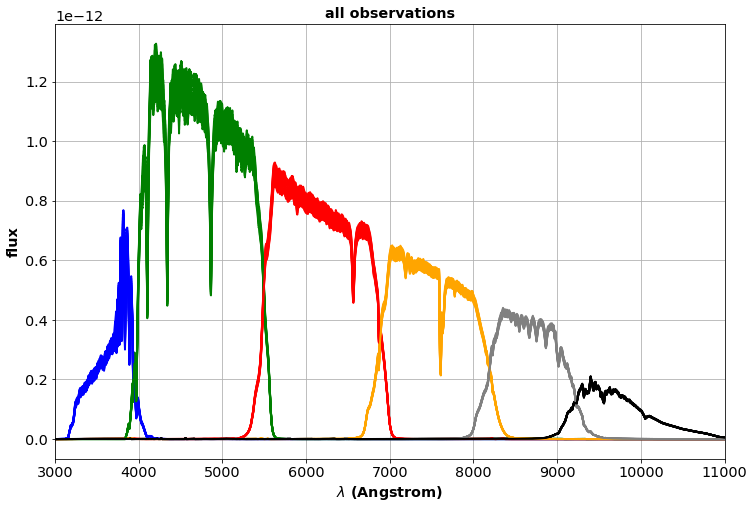

In [58]:
rt_observations.plot_observations(2)

### Magnitude

In [59]:
obssamplarray=rt_observations.make_samplobservations()

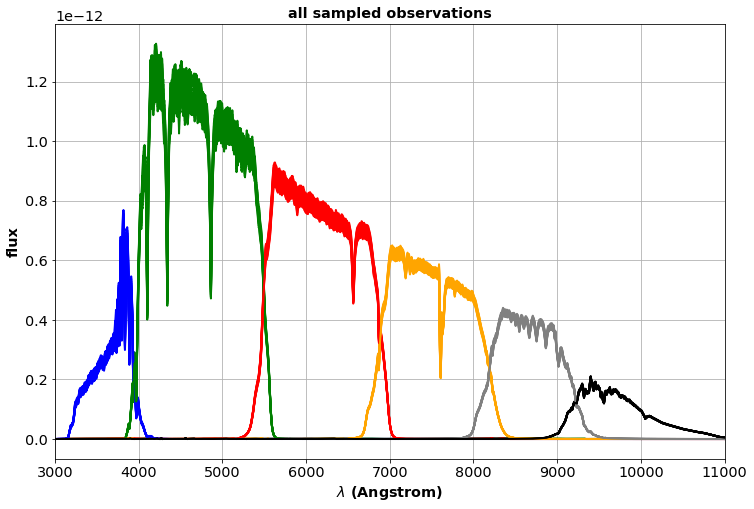

In [60]:
rt_observations.plot_samplobservations(2)

In [61]:
obssamplarray2=rt_observations2.make_samplobservations()

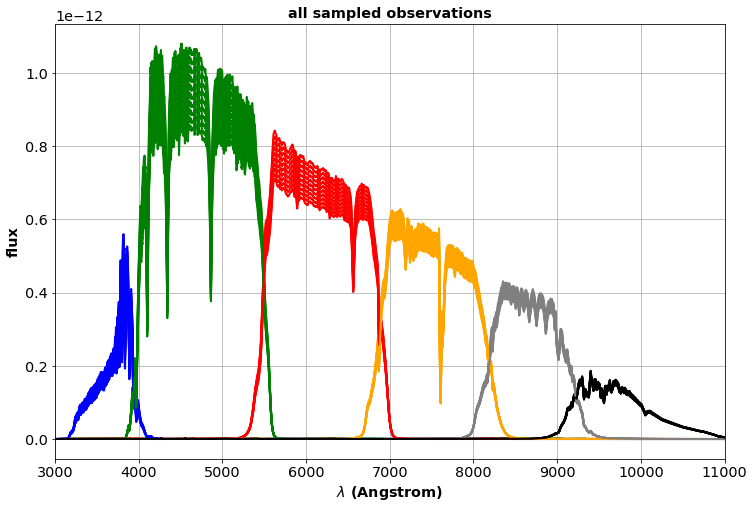

In [62]:
rt_observations2.plot_samplobservations(2)

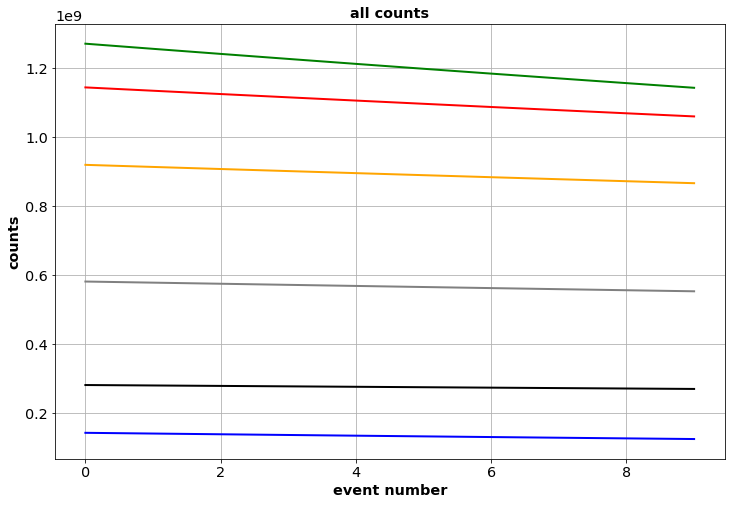

In [63]:
rt_observations.plot_counts(1)

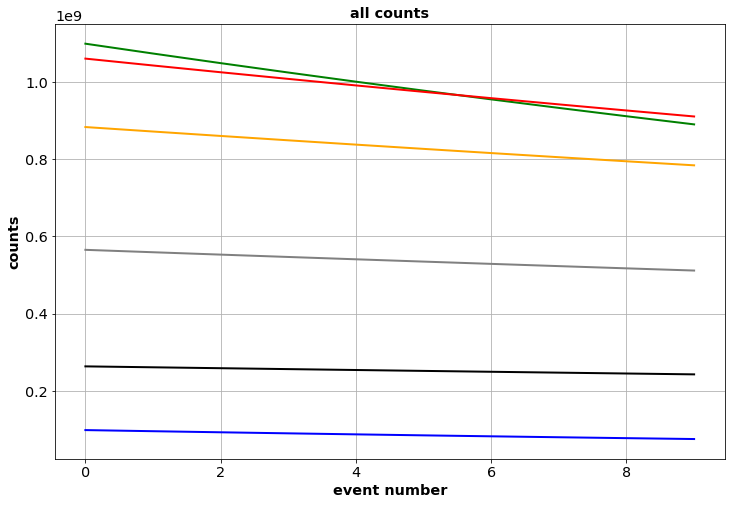

In [64]:
rt_observations2.plot_counts(1)

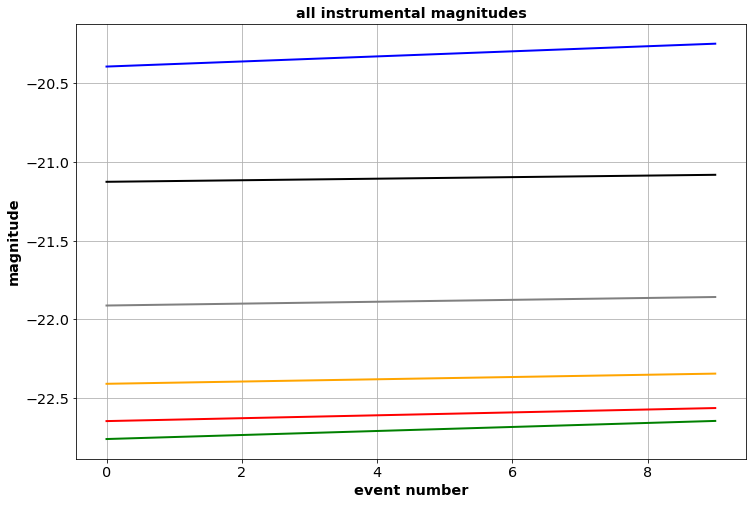

In [65]:
rt_observations.plot_magnitudes(1)

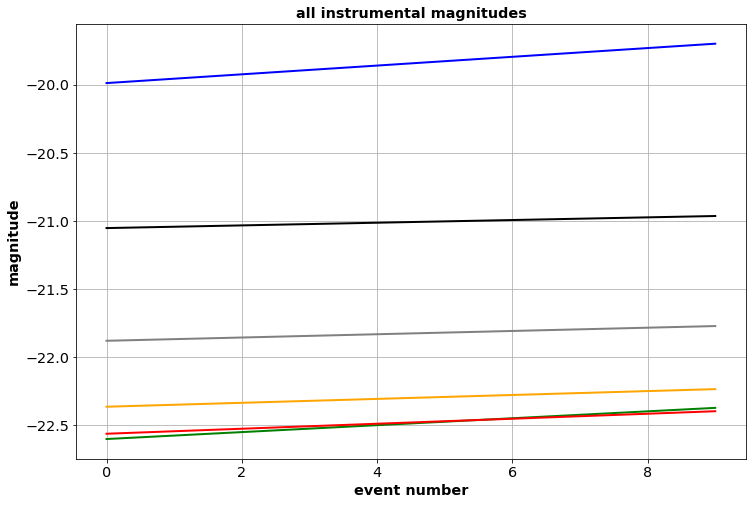

In [66]:
rt_observations2.plot_magnitudes(1)

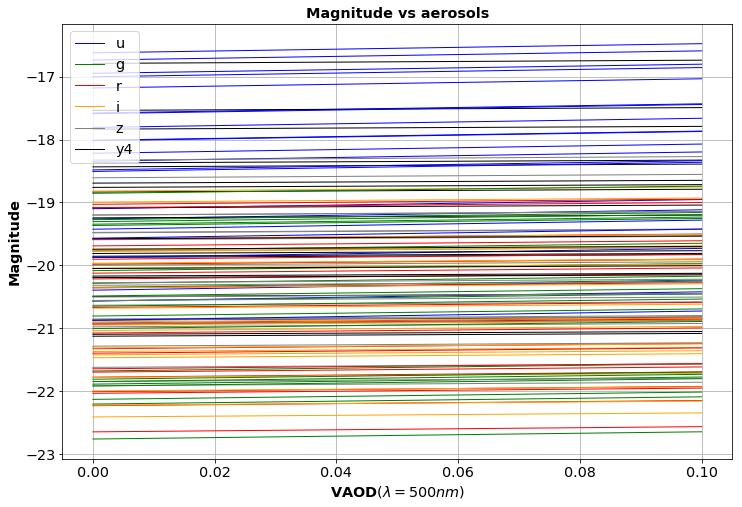

In [67]:
for ised in np.arange(NBSED):
    for ifilt in np.arange(photo.NBBANDS):
        mag=rt_observations.get_magnitudeforfilternum(ised,ifilt)
        if(ised==0):
            thelabel=photo.number_to_band[ifilt]
            plt.plot(tau_aerosol,mag,color=photo.filtercolor[ifilt],lw=1,label=thelabel)
        else:
            plt.plot(tau_aerosol,mag,color=photo.filtercolor[ifilt],lw=1)
plt.title("Magnitude vs aerosols",weight='bold')
plt.xlabel("VAOD$(\lambda=500nm)$",weight='bold')
plt.ylabel("Magnitude",weight='bold')
plt.legend(loc='best')
plt.grid()

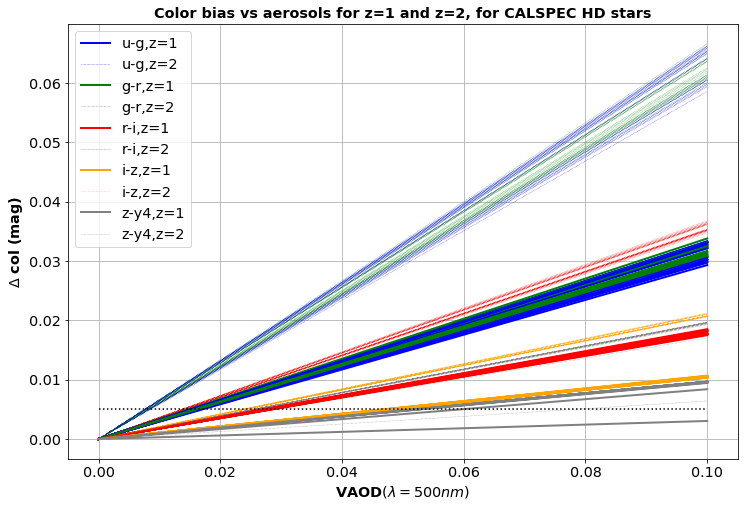

In [68]:
for ised in np.arange(NBSED):
    for ifilt in np.arange(photo.NBBANDS-1):
        mag1=rt_observations.get_magnitudeforfilternum(ised,ifilt)
        mag2=rt_observations.get_magnitudeforfilternum(ised,ifilt+1)
        
        mag3=rt_observations2.get_magnitudeforfilternum(ised,ifilt)
        mag4=rt_observations2.get_magnitudeforfilternum(ised,ifilt+1)    
        
        
        thelabel=photo.number_to_band[ifilt]+'-'+photo.number_to_band[ifilt+1]+',z=1'
        thelabel2=photo.number_to_band[ifilt]+'-'+photo.number_to_band[ifilt+1]+',z=2'
        deltamag=mag1-mag2 - (mag1[0]-mag2[0])
        deltamag2=mag3-mag4 - (mag3[0]-mag4[0])
        if(ised==0):
            plt.plot(tau_aerosol,deltamag,color=photo.filtercolor[ifilt],lw=2,label=thelabel)
            plt.plot(tau_aerosol,deltamag2,':',color=photo.filtercolor[ifilt],lw=0.5,label=thelabel2)
        else:
            plt.plot(tau_aerosol,deltamag,color=photo.filtercolor[ifilt],lw=2)
            plt.plot(tau_aerosol,deltamag2,':',color=photo.filtercolor[ifilt],lw=0.5)
plt.plot([tau_aerosol[0],tau_aerosol[-1]],[0.005,0.005],'k:')
plt.title("Color bias vs aerosols for z=1 and z=2, for CALSPEC HD stars",weight='bold')
plt.xlabel("VAOD$(\lambda=500nm)$",weight='bold')
plt.ylabel("$\Delta$ col (mag)",weight='bold')
plt.legend(loc='best')
plt.grid()
plt.savefig('ColorBias2zManyCalspec.png')